# Prepare

Please make sure all the properties and data already in the ./docs folder

# Image Alignment

## Find local image regions in each image

scene.pgm and book.pgm

In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
image_1_path = './docs/scene.pgm'
image_2_path = './docs/book.pgm'
image_1_title = "scene"
image_2_title = "book"

In [3]:
def show_image(image_path, image_tilte=None):
    image = cv2.imread(image_path,0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image)
    if image_tilte is not None:
        plt.title(image_tilte)

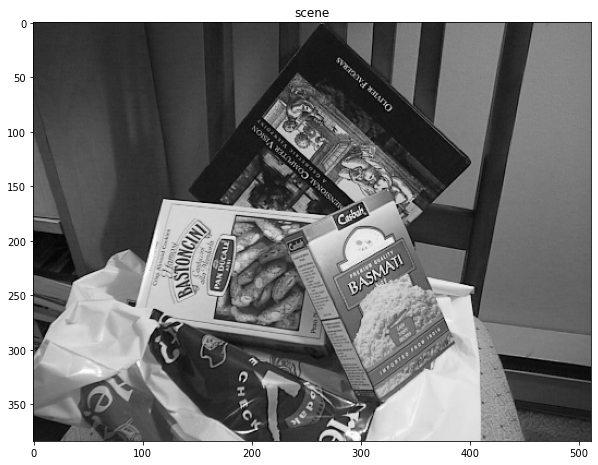

In [4]:
show_image(image_1_path, image_1_title)

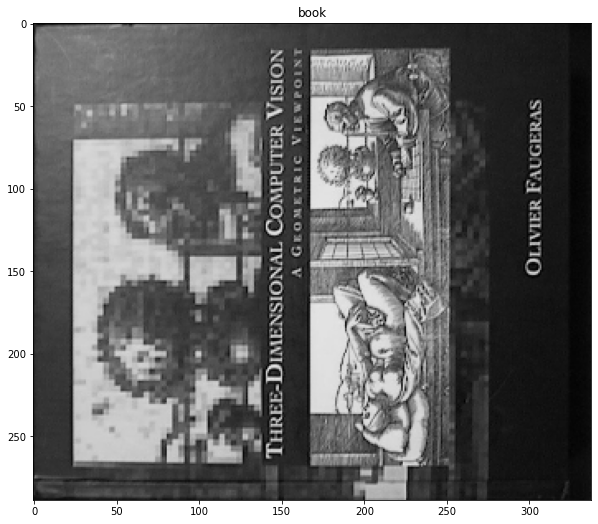

In [5]:
show_image(image_2_path, image_2_title)

## Characterize the local appearance of the regions: SIFT

In [6]:
import PythonSIFT.pysift as pysift

In [7]:
image_1 = cv2.imread(image_1_path,0)
keypoints_1, descriptor_1 = pysift.computeKeypointsAndDescriptors(image_1)
region_1 = cv2.drawKeypoints(image_1, keypoints_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [8]:
image_2 = cv2.imread(image_2_path,0)
keypoints_2, descriptor_2 = pysift.computeKeypointsAndDescriptors(image_2)
region_2 = cv2.drawKeypoints(image_2, keypoints_2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

### Plot Rigion Together

Text(0.5, 1.0, 'book')

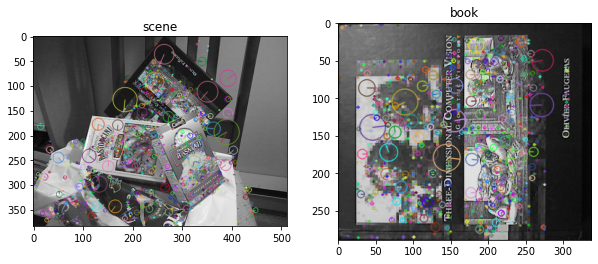

In [9]:
fig = plt.figure(figsize=(10, 10))
rows = 1
cols = 2
fig.add_subplot(rows, cols, 1)
plt.imshow(region_1)
plt.title(image_1_title)
fig.add_subplot(rows, cols, 2)
plt.imshow(region_2)
plt.title(image_2_title)

## Get set of putative matches between region descriptors in each image

This should be done as follows: for each descriptor in image 1, compute the closest neighbor amongst the descriptors from image 2 using Euclidean distance. Spurious matches can be removed by then computing the ratio of distances between the closest and second-closest neighbor and rejecting any matches that are above a certain threshold. To test the functioning of RANSAC, we want to have some erroneous matches in our set, thus this threshold should be set to a fairly slack value of 0.9. To check that your code is functioning correctly, plot out the two images side-by-side with lines showing the potential matches (include this in your report).

In [10]:
def get_putative_matches(descriptor_1, descriptor_2):
    threshold = 0.9
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptor_1, descriptor_2, k = 2)
    candidates = []
    for m, n in matches:
        if m.distance < threshold * n.distance: # only consider those within threshold
            candidates.append([m])
    fig = plt.figure(figsize=(10, 10))
    img = cv2.drawMatchesKnn(image_1, keypoints_1, image_2, keypoints_2, candidates, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.title("putative matches")
    plt.imshow(img)
    return candidates

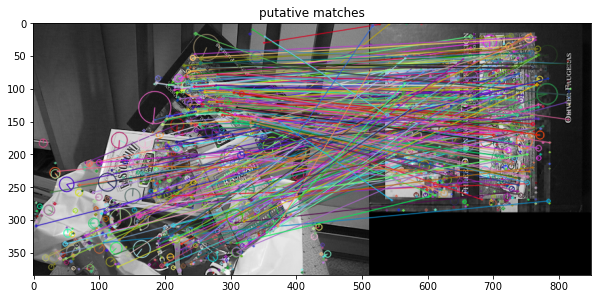

In [11]:
candidates = get_putative_matches(descriptor_1, descriptor_2)

## RANSAC

The ﬁnal stage, running RANSAC, should be performed as follows:

• Repeat N times (where N is ∼100):

• Pick P matches at random from the total set of matches T. Since we are solving for an aﬃne transformation which has 6 degrees of freedom, we only need to select P=3 matches.

• Construct a matrix A and vector b using the 3 pairs of points as described in lecture 12.

• Solve for the unknown transformation parameters q. In Python you can use linalg.solve.

• Using the transformation parameters, transform the locations of all T points in image 1. If the transformation is correct, they should lie close to their pairs in image 2.

• Count the number of inliers, inliers being deﬁned as the number of transformed points from image 1 that lie within a radius of 10 pixels of their pair in image 2.

• If this count exceeds the best total so far, save the transformation parameters and the set of inliers.

• End repeat.

• Perform a ﬁnal reﬁt using the set of inliers belonging to the best transformation you found. This reﬁt should use all inliers, not just 3 points chosen at random.

• Finally, transform image 1 using this ﬁnal set of transformation parameters, q. This can be done by ﬁrst forming a homography matrix H = [ q(1) q(2) q(5) ; q(3) q(4) q(6) ; 0 0 1 ]; and then using the cv2.warpAffine command from the OpenCV-Python environment. If you display this image you should ﬁnd that the pose of the book in the scene should correspond to its pose in image 2.

In [12]:
import numpy as np
import random
import math

### Conver CV2 Keypoints to numpy Array

In [13]:
candidates[0]

[<DMatch 0x7fde3c56a590>]

In [14]:
def get_candidates_keypoints():
    source_candidates_keypoints = np.array([keypoints_1[c[0].queryIdx].pt for c in candidates])
    target_candidates_keypoints = np.array([keypoints_2[c[0].trainIdx].pt for c in candidates])
    return source_candidates_keypoints, target_candidates_keypoints

In [15]:
source_candidates_keypoints, target_candidates_keypoints = get_candidates_keypoints()

In [16]:
source_candidates_keypoints.shape

(248, 2)

### RANSAC Definition

In [17]:
'''
description: RANSAC for best transformation
param {*} source_keypoints: keypoints in source image
param {*} target_keypoints: keypoints in target image
param {*} N: Repeat N times (where N is ∼100)
param {*} P: Pick P matches at random from the total set of matches T. Since we are solving for an affine transformation which has 6 degrees of freedom, we only need to select P=3 matches.
param {*} threshold: If the number of inliers is greater than threshold, then the transformation is considered to be good enough and we stop.
return {*}
'''
def RANSAC(source_keypoints, target_keypoints, N, P=3, threshold=10):
    best_inliers = []
    matches_num = source_keypoints.shape[0]
    for i in range(N):
        sample_num = random.sample(range(matches_num), P)
        # matrix A and vector b
        A = []
        b = []
        for j in range(P): # sample P=3 matches
            A.append([source_keypoints[sample_num[j]][0], source_keypoints[sample_num[j]][1], 1,0,0,0])
            A.append([0,0,0,source_keypoints[sample_num[j]][0], source_keypoints[sample_num[j]][1], 1])

            b.append([target_keypoints[sample_num[j]][0]])
            b.append([target_keypoints[sample_num[j]][1]])

        # Solve for the unknown transformation parameters q. In Python you can use linalg.solve.
        q = np.linalg.solve(A,b)
                
        # Using the transformation parameters, transform the locations of all T points in image 1. If the transformation is correct, they should lie close to their pairs in image 2.
        # test the quality of the transformation
        inliers = []
        for k in range(matches_num):  # test all matches
            A_test = []
            A_test.append([source_keypoints[k][0],source_keypoints[k][1],1,0,0,0])
            A_test.append([0,0,0,source_keypoints[k][0],source_keypoints[k][1],1])
            b_test = np.dot(A_test,q).reshape(2)
            # Count the number of inliers, inliers being defined as the number of transformed points from image 1 that lie within a radius of 10 pixels of their pair in image 2. 
            distance = math.dist(target_keypoints[k], b_test)
            if (distance <= threshold):
                inliers.append(k)
                
        # If this count exceeds the best total so far, save the transformation parameters and the set of inliers.
        # store best_inliers and best_q
        if (len(inliers) > len(best_inliers)):
            best_inliers = inliers
            best_q = q
    
    # Perform a final refit using the set of inliers belonging to the best transformation you found. This refit should use all inliers, not just 3 points chosen at random. 
    # Construct a matrix A and vector b using the best_inliers.
    A = []
    b = []
    for i in range(len(best_inliers)):
        A.append([source_keypoints[best_inliers[i]][0], source_keypoints[best_inliers[i]][1], 1,0,0,0])
        A.append([0,0,0,source_keypoints[best_inliers[i]][0], source_keypoints[best_inliers[i]][1],1])

        b.append([target_keypoints[best_inliers[i]][0]])
        b.append([target_keypoints[best_inliers[i]][1]])
    
    # Solve for the unknown transformation parameters q. In Python you can use linalg.solve.
    q = np.linalg.lstsq(A,b,rcond=None)[0].flatten()
    
    # Finally, transform image 1 using this final set of transformation parameters, q. 
    # This can be done by first forming a homography matrix H = [ q(1) q(2) q(5) ; q(3) q(4) q(6) ; 0 0 1 ]; 
    # and then using the cv2.warpAffine command from the OpenCV-Python environment. 
    # If you display this image you should find that the pose of the book in the scene should correspond to its pose in image 2.
    H = np.matrix([[q[0],q[1],q[2]],
                   [q[3],q[4],q[5]],
                   [0,0,1]],dtype=np.float32)
    return H

In [18]:
H = RANSAC(source_keypoints=source_candidates_keypoints, target_keypoints=target_candidates_keypoints, N=100, P=3, threshold=10)

## (i) the transformed image 1

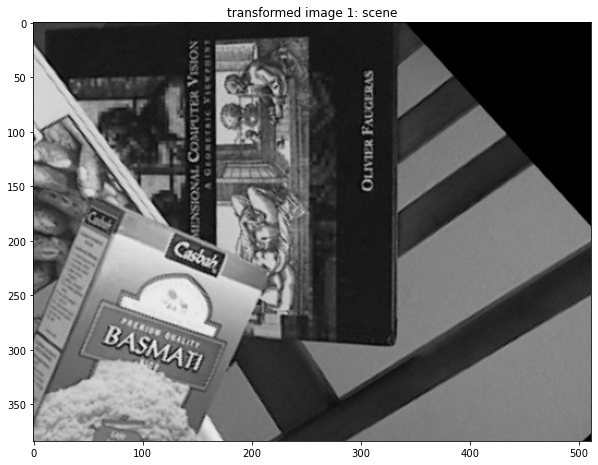

In [19]:
image_1_t = cv2.warpPerspective(image_1, H, (image_1.shape[1],image_1.shape[0]))
image_1_t = cv2.cvtColor(image_1_t, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10, 10))
plt.imshow(image_1_t)
plt.title("transformed image 1: scene")
plt.show()

### Compare to Image 2

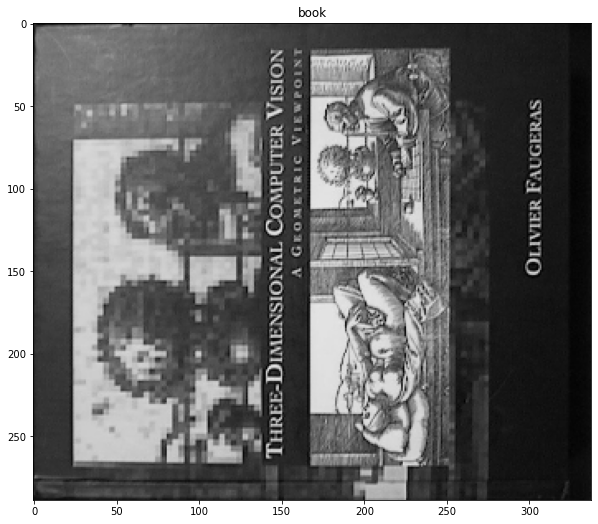

In [20]:
show_image(image_2_path, image_2_title)

## (ii) the values in the matrix H.

In [21]:
H

matrix([[   1.1109897,   -1.200254 ,   38.003445 ],
        [   1.2170446,    1.0726768, -330.6448   ],
        [   0.       ,    0.       ,    1.       ]], dtype=float32)

# Estimating the Camera Parameters

## (a) Find the 3x4 matrix P that projects the world points X to the 10 image points x.

This should be done in the following steps:
Since P is a homogeneous matrix, the world and image points (which are 3 and 2-D respectively), need to be converted into homogeneous points by concatenating a 1 to each of them (thus becoming 4 and 3-D respectively).

• We now note that x × PX = 0, irrespective of the scale ambiguity.

This allows us to setup a series of linear equations of the form:

for each correspondence x i ↔ X i , where x i = (x i , y i , w i ) T , w i being the homogeneous coordinate, and P j is the j th row of P. But since the 3rd row is a linear combination of the ﬁrst two, we need only consider the ﬁrst two rows for each correspondence i. Thus, you should form a 20 by 12 matrix A, each of the 10 correspondences contributing two rows. This yields Ap = 0, p being the vector containing the entries of matrix P.

• To solve for p, we need to impose an extra constraint to avoid the trivial solution p = 0. One simple one is to use || p || 2 = 1. This constraint is implicitly imposed when we compute the SVD of A. The value of p that minimizes Ap subject to || p || 2 = 1 is given by the eigenvector corresponding to the smallest singular value of A. To ﬁnd this, compute the SVD of A, picking this eigenvector and reshaping it into a 3 by 4 matrix P.

• Verify your answer by re-projecting the world points X and checking that they are close to x.

### Load File

In [22]:
file_1_path = './docs/world.txt'
file_2_path = './docs/image.txt'

In [23]:
world_points = np.loadtxt(file_1_path)
image_points = np.loadtxt(file_2_path)

### homogeneous points
the world and image points (which are 3 and 2-D respectively), need to be converted into homogeneous points by concatenating a 1 to each of them (thus becoming 4 and 3-D respectively).

In [24]:
print(world_points.shape)

(3, 10)


In [25]:
world_homogeneous_points = np.append(world_points, np.ones((1, world_points.shape[1])), axis=0)
image_homogeneous_points = np.append(image_points, np.ones((1, world_points.shape[1])), axis=0)

In [26]:
world_homogeneous_points

array([[0.8518447 , 0.55793851, 0.81620571, 0.70368367, 0.71335444,
        0.1721997 , 0.04904683, 0.28614965, 0.13098247, 0.84767647],
       [0.75947939, 0.01423302, 0.97709235, 0.52206092, 0.2280389 ,
        0.96882014, 0.75533857, 0.25120055, 0.94081954, 0.20927164],
       [0.94975928, 0.59617708, 0.22190808, 0.93289706, 0.4496421 ,
        0.3557161 , 0.89481276, 0.93273619, 0.70185317, 0.45509169],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]])

In [27]:
world_homogeneous_points.shape

(4, 10)

In [28]:
zeros_4d = np.zeros((4, 1))
A = np.zeros((1,12))

for i in range(10):
    xi = image_homogeneous_points[:, i].reshape(3,1)
    yi = xi[1]
    wi = xi[2]
    xi = xi[0]
    Xi = world_homogeneous_points[:, i].reshape(4,1)

    A1 = np.concatenate((zeros_4d.T, -wi * Xi.T, yi * Xi.T), axis=1)
    A2 = np.concatenate((wi *  Xi.T, zeros_4d.T, -xi * Xi.T), axis=1)

    A = np.append(A, A1, axis=0)
    A = np.append(A, A2, axis=0)
A = A[1:,:]

### Compute the SVD of A, picking this eigenvector and reshaping it into a 3 by 4 matrix P.
eigenvector corresponding to the smallest singular value of A

In [29]:
u,s,vh = np.linalg.svd(A)
P = vh[-1].reshape(3,4)

In [30]:
P.shape

(3, 4)

### Re-projecting the world points X and checking that they are close to x.

In [31]:
world_homogeneous_points = np.append(world_points, np.ones((1, world_points.shape[1])), axis=0)
image_homogeneous_points = np.append(image_points, np.ones((1, world_points.shape[1])), axis=0)

In [32]:
world_homogeneous_points.shape

(4, 10)

In [33]:
reprojection_points = np.dot(P, world_homogeneous_points)

In [34]:
reprojection_points.shape

(3, 10)

### checking that they are close to x

In [35]:
reprojection_points

array([[-1.1709515 , -0.80961766, -0.94438751, -1.08540616, -0.82783237,
        -0.91147842, -1.04700965, -0.9635194 , -1.03101003, -0.84220068],
       [-1.0903387 , -0.56728509, -0.97027031, -0.92033328, -0.69047666,
        -0.67395048, -0.66698289, -0.60498703, -0.73026278, -0.75294618],
       [-0.22880393, -0.14657283, -0.13184058, -0.20784596, -0.14770071,
        -0.06704537, -0.11987029, -0.15479866, -0.10577023, -0.16545172]])

In [36]:
for i in range(reprojection_points.shape[0]):
    for j in range(reprojection_points.shape[1]):
        reprojection_points[i,j] /= reprojection_points[2,j] 
print(np.allclose(reprojection_points, image_homogeneous_points))

True


In [37]:
reprojection_points

array([[ 5.11770701,  5.5236545 ,  7.16310171,  5.22216628,  5.60479614,
        13.59494885,  8.73452189,  6.22433952,  9.74763886,  5.09031079],
       [ 4.76538441,  3.87032917,  7.35942066,  4.4279585 ,  4.67483648,
        10.05215495,  5.56420531,  3.90821885,  6.90423723,  4.5508513 ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

### 1. we can compute the world coordinates of the projection center of the camera C

In [38]:
u,s,vh = np.linalg.svd(P)
C = vh[-1, :]
C = np.array([[float(C[0] / C[-1]), float(C[1] / C[-1]), float(C[2] / C[-1])]])

#### matrix P and the value of ˜C

In [39]:
print("matrix P:\n", P)

matrix P:
 [[-1.27000127e-01 -2.54000254e-01 -3.81000381e-01 -5.08000508e-01]
 [-5.08000508e-01 -3.81000381e-01 -2.54000254e-01 -1.27000127e-01]
 [-1.27000127e-01  5.18132268e-17 -1.27000127e-01  4.67614084e-18]]


In [40]:
print("matrix C:\n", C)

matrix C:
 [[ 1. -1. -1.]]


### 2. we decompose P into it’s constituent matrices.

In [43]:
from scipy import linalg
import scipy

In [44]:
K, R = scipy.linalg.rq(P,mode='economic')
t = R.T[3]
R = R[:,:3]
# t = -RC
C_2 = np.matrix(np.linalg.solve(-R,t))
print("matrix C:\n",C_2)

matrix C:
 [[ 1. -1. -1.]]


#### check C and C_2

In [45]:
print ("C agress with C_2: \n",np.allclose(C,C_2))

C agress with C_2: 
 True


# Structure from Motion

• Compute the translations t idirectly by computing the centroid of point in each image i.

• Center the points in each image by subtracting oﬀ the centroid, so that the points have zero mean

• Construct the 2m by n measurement matrix W from the centered data.

• Perform an SVD decomposition of W into UDV T .

• The camera locations M i can be obtained from the ﬁrst three columns of U multiplied by D(1 : 3, 1 : 3), the ﬁrst three singular values.

• The 3D world point locations are the ﬁrst three columns of V . CSCI-GA.2272-001

• You can verify your answer by plotting the 3D world points out using the matplotlib package, via the plot3 command. The rotate3d command will let you rotate the plot.

In [46]:
import scipy.io as sio

In [47]:
file_path = "./docs/sfm_points.mat"
mat = sio.loadmat(file_path)

In [48]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Oct 23 00:15:37 2008',
 '__version__': '1.0',
 '__globals__': [],
 'image_points': array([[[ 0.26325438, -0.49056183,  0.27474182, ..., -0.64224384,
          -0.04651497, -0.28600555],
         [ 0.3520294 , -0.50409164,  0.27452285, ..., -0.70095759,
          -0.08464344, -0.3733775 ],
         [ 0.42545959, -0.62080198, -0.3166855 , ..., -0.3961415 ,
          -0.55167564, -0.4613689 ],
         ...,
         [-0.19745801, -0.13759005, -0.25208177, ...,  0.2071425 ,
          -0.13475769,  0.17921768],
         [ 0.10206014,  0.37085405, -0.59861843, ...,  0.58987469,
          -0.35010672, -0.08256311],
         [ 0.17139037, -0.41993245, -0.37977628, ..., -0.08460589,
          -0.4421403 , -0.20111876]],
 
        [[-0.32157959,  0.04275576, -0.38902085, ...,  0.04304661,
           0.46633676, -0.53427061],
         [-0.37910652, -0.01051739, -0.37942066, ...,  0.12344693,
           0.56420891, -0.5809847

In [49]:
images_points = mat['image_points']

In [50]:
images_points.shape

(2, 600, 10)

In [51]:
def get_centeroid(arr):
    length = arr.shape[1]
    sum_x = np.sum(arr[0, :])
    sum_y = np.sum(arr[1, :])
    return sum_x/length, sum_y/length

In [52]:
centroids = np.zeros((2,1))

for i in range(10):
    x,y = get_centeroid(mat["image_points"][:, :, i])
    centroids = np.append(centroids, [[x],[y]], axis=1)
centroids = centroids[:, 1:]

In [53]:
centroids = np.matrix(centroids)

In [54]:
centroids

matrix([[ 2.36847579e-17, -3.55271368e-17,  9.47390314e-17,
          3.07901852e-16,  8.28966525e-17,  4.73695157e-17,
          4.73695157e-17,  7.10542736e-17,  0.00000000e+00,
         -1.18423789e-17],
        [ 8.28966525e-17,  4.73695157e-17,  0.00000000e+00,
          1.18423789e-17, -3.55271368e-17,  0.00000000e+00,
          2.36847579e-17, -7.10542736e-17,  4.73695157e-17,
          1.42108547e-16]])

### Center the points in each image by subtracting off the centroid, so that the points have zero mean.  

In [55]:
W = []
for i in range(10):
    images_points[:,:,i] -= centroids[:,i]
    W.append(images_points[0,:,i])
    W.append(images_points[1,:,i])
W = np.matrix(W)

In [56]:
W.shape

(20, 600)

In [57]:
W

matrix([[ 0.26325438,  0.3520294 ,  0.42545959, ..., -0.19745801,
          0.10206014,  0.17139037],
        [-0.32157959, -0.37910652,  0.31660603, ...,  0.49352826,
          0.49352826,  0.49352826],
        [-0.49056183, -0.50409164, -0.62080198, ..., -0.13759005,
          0.37085405, -0.41993245],
        ...,
        [ 0.46633676,  0.56420891,  0.04464354, ..., -0.49976548,
         -0.39307225, -0.26418189],
        [-0.28600555, -0.3733775 , -0.4613689 , ...,  0.17921768,
         -0.08256311, -0.20111876],
        [-0.53427061, -0.5809847 ,  0.00215219, ...,  0.34359709,
          0.68046649,  0.23970257]])

### SVD W

In [58]:
U,D,VT = np.linalg.svd(W)
D = np.diag(D)

### MI
The camera locations Mi can be obtained from the first three columns of U multiplied by D(1 : 3, 1 : 3), the first three singular values.

In [59]:
D = D[:3,:3]  
Mi = np.dot(U[:,:3],D)

The 3D world point locations are the first three columns of V.

In [60]:
V = VT.T
V = V[:,:3]

### Plot 3D world points

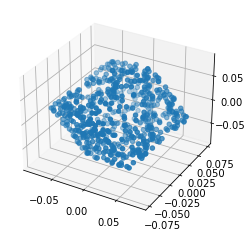

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V.T[0], V.T[1], V.T[2])
plt.show()

### Print Mi for First Camera

In [62]:
Mi.shape

(20, 3)

In [63]:
Mi_1 = Mi[:2]
print("Mi for the first camera: \n", Mi_1)

Mi for the first camera: 
 [[-7.50914219  3.30837904 -3.71763726]
 [-4.53754376 -1.57773527  7.74574759]]


### Print ti for First Camera

In [64]:
ti_1 = centroids.T[0]
print("ti for the first camera: \n", ti_1)

ti for the first camera: 
 [[2.36847579e-17 8.28966525e-17]]


### Print out the 3D coordinates of the first 10 world points

In [65]:
print("3D coordinates of the first 10 world points: \n", V.T[:,:10])

3D coordinates of the first 10 world points: 
 [[ 0.00577163  0.0005761  -0.04293585  0.04745038 -0.04210186  0.05961964
   0.00909167  0.01039489 -0.02589081  0.01745598]
 [ 0.06460628  0.06885363  0.06330479  0.04904207  0.06789239  0.0460518
   0.06002049  0.04602065  0.05702972  0.04054264]
 [-0.02497615 -0.03458151  0.02861711 -0.01257547  0.01175164 -0.01438374
  -0.01229997  0.03529275  0.03337375  0.04731859]]


#### coordinate first

In [66]:
V.T[:,:10].T

matrix([[ 0.00577163,  0.06460628, -0.02497615],
        [ 0.0005761 ,  0.06885363, -0.03458151],
        [-0.04293585,  0.06330479,  0.02861711],
        [ 0.04745038,  0.04904207, -0.01257547],
        [-0.04210186,  0.06789239,  0.01175164],
        [ 0.05961964,  0.0460518 , -0.01438374],
        [ 0.00909167,  0.06002049, -0.01229997],
        [ 0.01039489,  0.04602065,  0.03529275],
        [-0.02589081,  0.05702972,  0.03337375],
        [ 0.01745598,  0.04054264,  0.04731859]])